# concave-hull

https://github.com/cubao/concave_hull

install:

```bash
pip install concave_hull
```

It relys on some kind of convex hull algorithm.
You may use [scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html).

>   Convex hull is deterministic, and simpler in this sense comparing to concave hull.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

from concave_hull import concave_hull_indexes

## 2D example

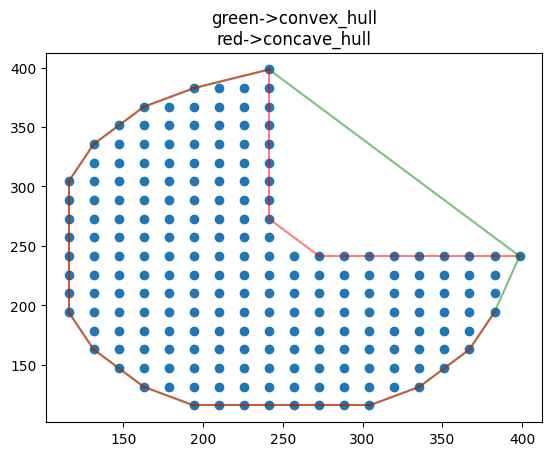

In [2]:
def sample_points():
    points = []
    c = np.array([250, 250])
    for x in np.arange(100, 400, 5 * np.pi):
        for y in np.arange(100, 400, 5 * np.pi):
            if x > c[0] and y > c[1]:
                continue
            r = np.linalg.norm(c - [x, y])
            if r > 150:
                continue
            points.append([x, y])
    points = np.array(points)
    return points

points = sample_points()

# convex hull of these points
convex_hull = ConvexHull(points)

plt.plot(points[:, 0], points[:, 1], "o")
for simplex in convex_hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], "g-", alpha=0.5)

# concave hull of these points
idxes = concave_hull_indexes(
    points[:, :2],
    convex_hull_indexes=convex_hull.vertices.astype(np.int32),
    length_threshold=50,
)

for f, t in zip(idxes[:-1], idxes[1:]):
    seg = points[[f, t]]
    plt.plot(seg[:, 0], seg[:, 1], "r-", alpha=0.5)

plt.title("green->convex_hull\nred->concave_hull")
plt.show()

## 3D example

You need to install meshcat:

```bash
python3 -m pip install git+https://github.com/rdeits/meshcat-python
```

In [3]:
import meshcat
import meshcat.geometry as g

vis = meshcat.Visualizer()
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
scale = 1e-3
raw_points = np.load('data/lane_lines.npy')
print(raw_points.shape, raw_points.dtype)
points = raw_points.astype(np.float32).T * scale
colors = np.zeros(points.shape).astype(np.float32)
colors[1, :] = 1.0

(8231, 3) float64


In [5]:
vis['all_points'].set_object(g.Points(
    g.PointsGeometry(points, color=colors),
    g.PointsMaterial(size=2*scale)
))

In [6]:
convex_hull = ConvexHull(raw_points[:, :2]) # important: should be 2D!!!
concave_hull = concave_hull_indexes(
    raw_points[:, :2],
    convex_hull_indexes=convex_hull.vertices.astype(np.int32),
    concavity = 2.0,
    length_threshold=3.0,
)
# concave_hull = [*concave_hull, concave_hull[0]]
hull_points = raw_points[concave_hull]
print(hull_points.shape)

(1422, 3)


In [7]:
lift = [0, 0, 10]
vis['concave_hull'].set_object(g.Line(
    g.PointsGeometry((hull_points + lift).T.astype(np.float32) * scale),
    g.MeshToonMaterial(color=0xff0000, linewidth=3.0)
))